# Introduction

...

# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib
import clearsky_detect_model_free
import preprocess

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

import warnings

%load_ext autoreload
%autoreload 2

# Setup

## Load data

In [2]:
def load_snl():
    filename = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
    cols = ['Global_Wm2', 'Date-Time']
    data = pd.read_csv(filename, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])
    data.index = data.index.tz_localize('Etc/GMT+7')
    data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq='1min')).fillna(0)
    data = pd.Series(data['Global_Wm2'], index=data.index)
    data[data < 50] = 0 
    return data

In [3]:
def load_srrl():
    srrl_file = os.path.expanduser('~/data_sets/srrl/20140101.csv')
    srrl_data = pd.read_csv(srrl_file)
    srrl_data.index = pd.to_datetime(srrl_data['DATE (MM/DD/YYYY)'] + ' ' + srrl_data['MST'])
    srrl_data.index = srrl_data.index.tz_localize('Etc/GMT+7')
    srrl_data = srrl_data[~srrl_data.index.duplicated(keep='first')]
    srrl_data.drop(['DATE (MM/DD/YYYY)', 'MST'], inplace=True, axis=1)
    srrl_data = pd.Series(srrl_data['Global 40-South LI-200 [W/m^2]'], index=srrl_data.index)
    srrl_data[srrl_data < 50] = 0
    srrl_data2 = pd.Series(0, index=pd.date_range(start=srrl_data.index.date[0], end=srrl_data.index.date[-1] + pd.Timedelta('1D'), freq='1min'))
    srrl_data2.index = srrl_data2.index.tz_localize('Etc/GMT+7')
    srrl_data2[srrl_data.index] = srrl_data
    srrl_data = srrl_data2.copy()
    return srrl_data

In [4]:
snl_data = load_snl()
srrl_data = load_srrl()

## Set up PVLib systems

In [5]:
def make_pvlib_sys(tilt, elevation, azimuth, lat, lon):
    sys_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=tilt, surface_azimuth=azimuth)
    sys_loc = pvlib.location.Location(lat, lon, altitude=elevation)
    sys = pvlib.pvsystem.LocalizedPVSystem(pvsystem=sys_no_loc, location=sys_loc)
    return sys

In [6]:
snl_params = {'tilt': 35, 'elevation': 1658, 'azimuth': 180, 'lat': 35.0549, 'lon': -106.5433}
rtc = make_pvlib_sys(**snl_params)

In [7]:
srrl_params = {'tilt': 40, 'elevation': 1828.8, 'azimuth': 180, 'lat': 39.742, 'lon': -105.18}
srrl = make_pvlib_sys(**srrl_params)

## Analysis functions

In [8]:
def compare_plot(sample, quantile_clear, pvlib_clear, model_free_clear):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 5), sharex=False)

    ax = axes[0]
    _ = ax.plot(sample.index, sample)
    _ = ax.scatter(sample.index[quantile_clear & ~pvlib_clear], sample[quantile_clear & ~pvlib_clear], 
                   facecolor='none', edgecolor='green', label='quantile')
    _ = ax.scatter(sample.index[pvlib_clear & ~quantile_clear], sample[pvlib_clear & ~quantile_clear], 
                   facecolor='none', edgecolor='red', label='pvlib')
    _ = ax.scatter(sample.index[quantile_clear & pvlib_clear], sample[quantile_clear & pvlib_clear], 
                   facecolor='none', edgecolor='orange', label='both')
    _ = ax.scatter(sample.index[model_free_clear], sample[model_free_clear], 
                   marker='x', color='black', label='model_free', alpha=.1)
    _ = ax.legend()
    
        
    # ax = axes[1]
    # _ = ax.plot(is_clear.index, np.cumsum(is_clear.astype(int)), label='unfiltered')
    # _ = ax.plot(is_clear_filtered.index, np.cumsum(is_clear_filtered.astype(int)), label='filtered')
    # _ = ax.plot(is_clear_pvlib.index, np.cumsum(is_clear_pvlib.astype(int)), label='pvlib')
    # _ = ax.legend()
    tmp_df = pd.DataFrame()

    tmp_df['quantile'] = quantile_clear
    tmp_df['pvlib'] = pvlib_clear
    tmp_df['model free'] = model_free_clear
    tmp_df = tmp_df.resample('D').sum()
    tmp_df.index = tmp_df.index.date
    
    tmp_df.plot(kind='bar', ax=axes[1])    
    fig.tight_layout()

In [9]:
def model_free_filter_detection(data):
    filtered_data = preprocess.zscore_time_filter(data, verbose=False, viz=False)
    is_clear_filtered = clearsky_detect_model_free.model_free_detect_democratic(filtered_data, verbose=False)
    return is_clear_filtered

In [10]:
def quantile_filtering(data, pvlib_site, q=.85, smoothing_window=30):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        by_time = preprocess.series_to_df_by_time(data)
        quantile = by_time.quantile(q, axis=1) # 85% 
        quantile = quantile.rolling(smoothing_window, center=True).mean() # smooth curve

        fig, ax = plt.subplots(figsize=(8, 2.5))
        by_time.plot(ax=ax, legend=False)
        quantile.plot(ax=ax, color='black', linestyle='--')

        series_list = []
        for day, group in sample.groupby(sample.index.date):
            ser = pd.Series(quantile.values, index=group.index)
            series_list.append(ser)
        quantile_cs = pd.concat(series_list)

        quantile_clear = pvlib.clearsky.detect_clearsky(sample, quantile_cs, sample.index, 10)
        model_cs = pvlib_site.get_clearsky(sample.index)
        model_cs = pd.Series(model_cs['ghi'], index=sample.index)
        model_clear = pvlib.clearsky.detect_clearsky(sample, model_cs, sample.index, 10)
        
        model_free_clear = model_free_filter_detection(data)

        compare_plot(sample, quantile_clear, model_clear, model_free_clear)
        
        df = pd.DataFrame()
        df['quantile'] = quantile_clear
        df['pvlib'] = model_clear
        
        only_quantile = len(df[(df['quantile']) & (~df['pvlib'])])
        only_pvlib = len(df[(~df['quantile']) & (df['pvlib'])])
        both = len(df[(df['quantile']) & (df['pvlib'])])
        
        print('Qunatile only: {}, pvlib only: {}, both: {}'.format(only_quantile, only_pvlib, both))

# Investigation

## SNL RTC

In [11]:
sample = snl_data[(snl_data.index >= '2016-07-01') & (snl_data.index < '2016-08-01')]

<IPython.core.display.Javascript object>


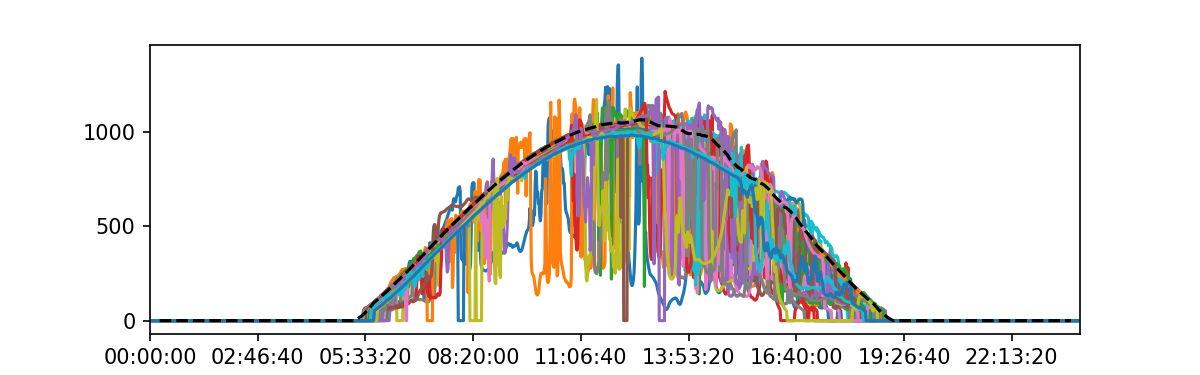

<IPython.core.display.Javascript object>


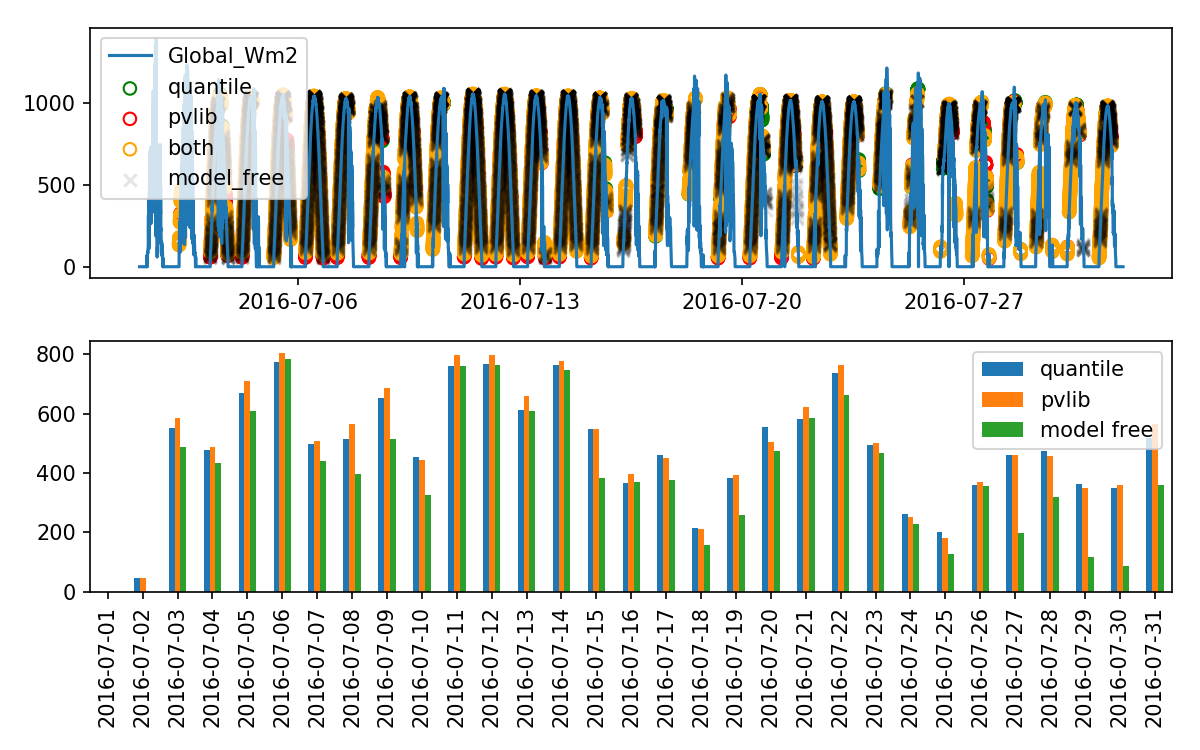

Qunatile only: 271, pvlib only: 658, both: 14602


In [12]:
quantile_filtering(sample, rtc, q=.9)

In [13]:
sample = snl_data[(snl_data.index >= '2016-01-01') & (snl_data.index < '2016-02-01')]

<IPython.core.display.Javascript object>


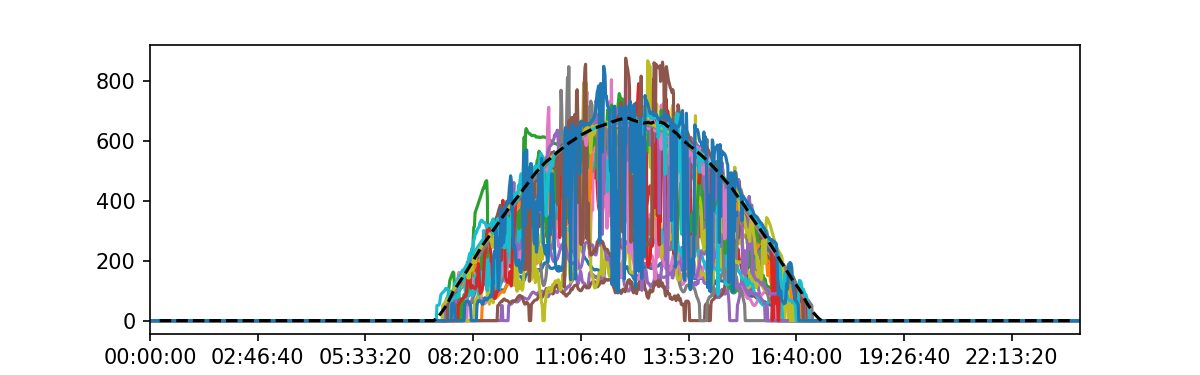

<IPython.core.display.Javascript object>


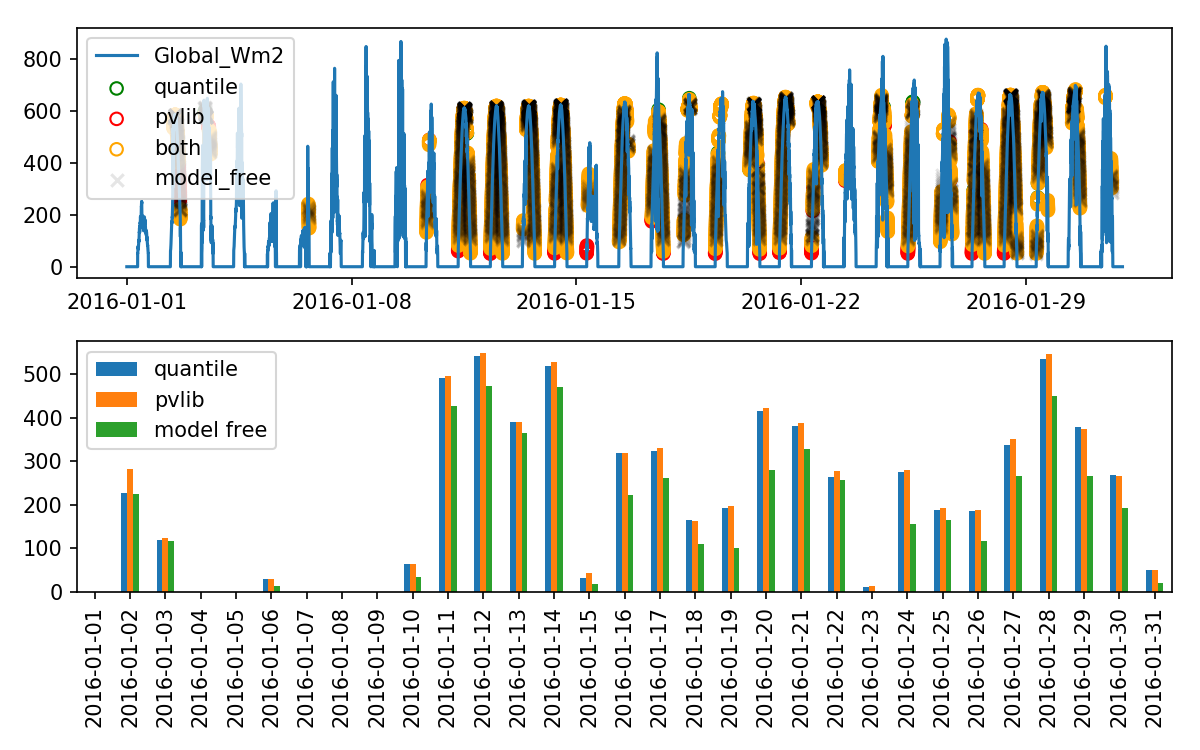

Qunatile only: 34, pvlib only: 195, both: 6669


In [14]:
quantile_filtering(sample, rtc, q=.9)

## SRRL

In [15]:
sample = srrl_data[(srrl_data.index >= '2014-01-01') & (srrl_data.index < '2014-02-01')]

<IPython.core.display.Javascript object>


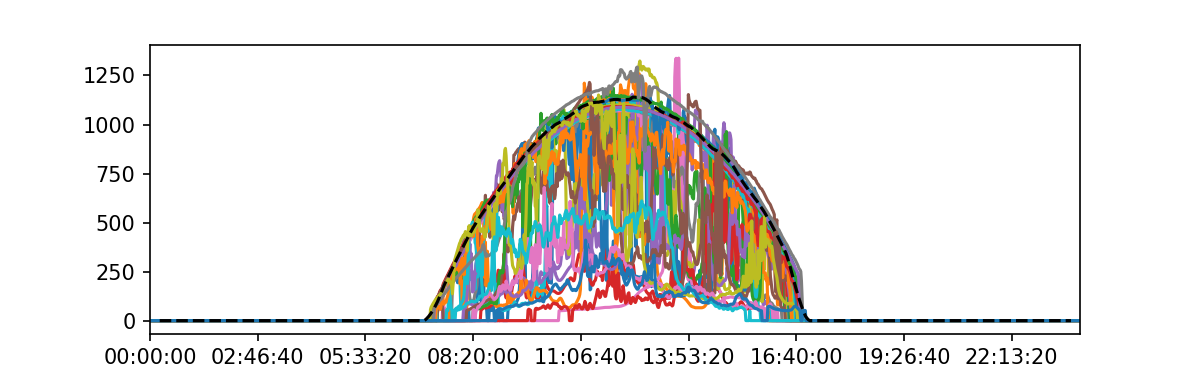

<IPython.core.display.Javascript object>


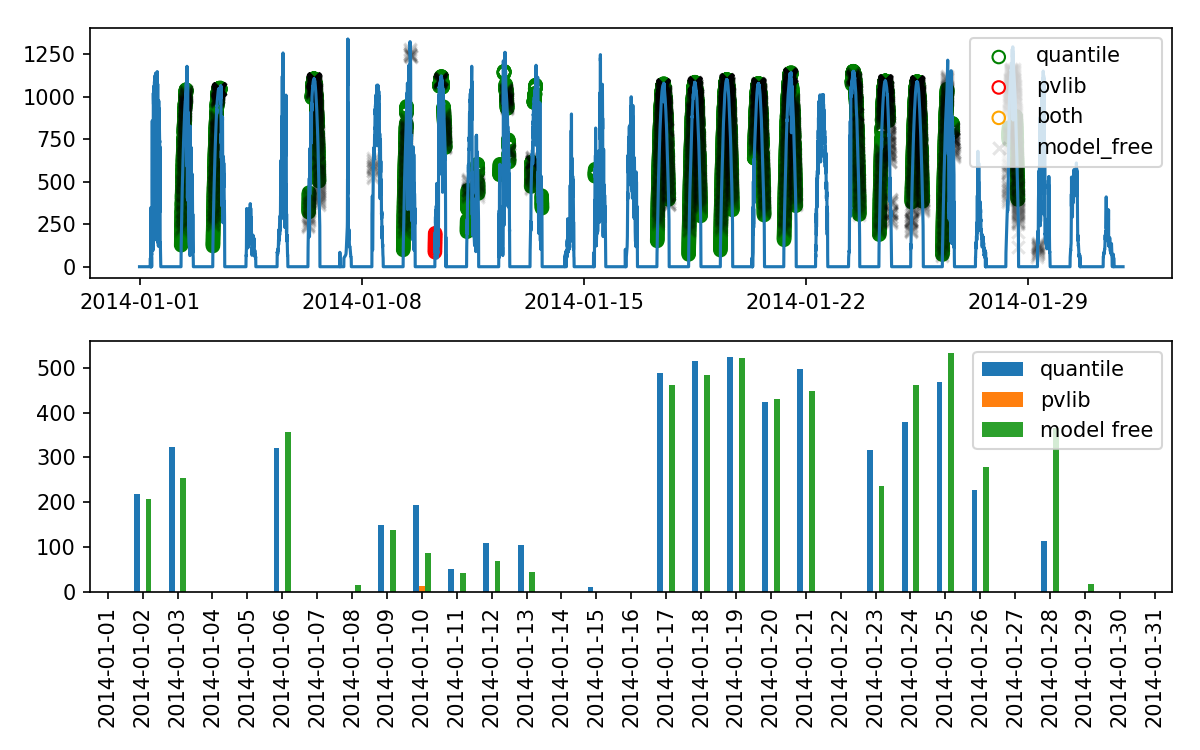

Qunatile only: 5429, pvlib only: 13, both: 0


In [16]:
quantile_filtering(sample, srrl, q=.9)

In [17]:
sample = srrl_data[(srrl_data.index >= '2014-07-01') & (srrl_data.index < '2014-08-01')]

<IPython.core.display.Javascript object>


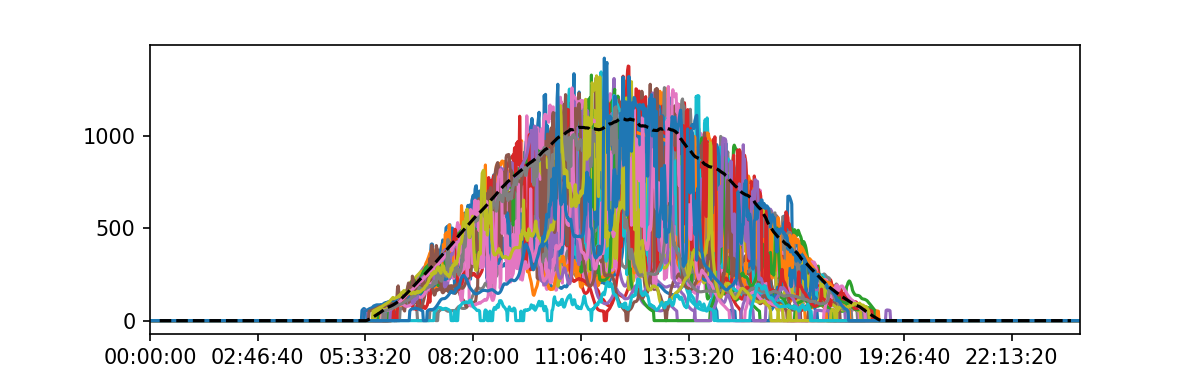

<IPython.core.display.Javascript object>


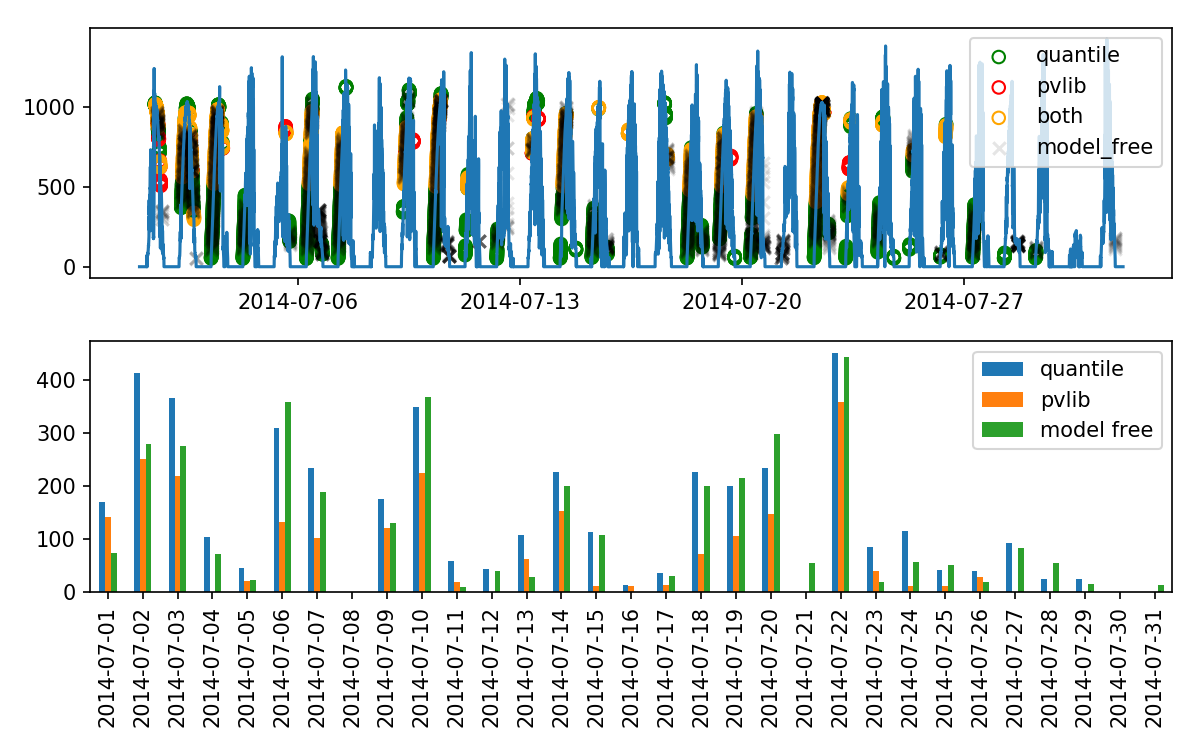

Qunatile only: 2221, pvlib only: 175, both: 2067


In [18]:
quantile_filtering(sample, srrl)

# Conclusion

Using the quantiles (specifically the 85 percentile) works quite well.  This is especially notable as we were able to use the same parameters for two different sites where using PVLib model irradiance failed (SRRL).  It was also encouraging to see that at SNL RTC (where PVLib model clear skies performs well), both the quantile and modeled clear skies yielded very similar results.

# Misc

In [19]:
sample = snl_data[(snl_data.index >= '2016-01-01') & (snl_data.index < '2017-01-01')]

<IPython.core.display.Javascript object>


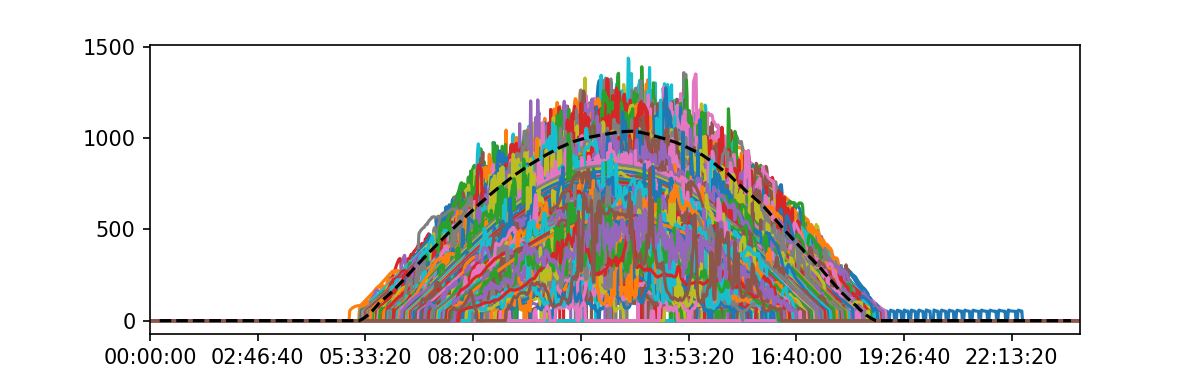

<IPython.core.display.Javascript object>


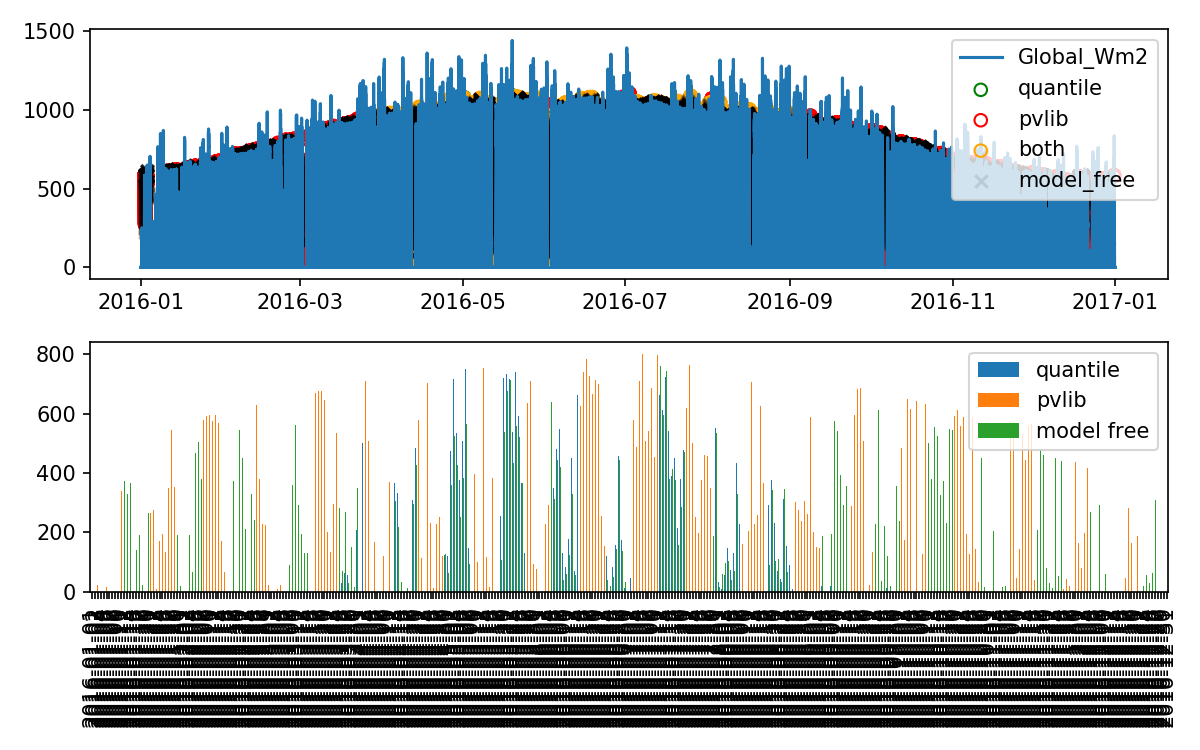

Qunatile only: 1359, pvlib only: 59808, both: 46968


In [20]:
quantile_filtering(sample, srrl)

dangers of using quantile based clear sky curve with large sample.  seasonal affects lead to winter months being labeled as obscured much more frequently (almost uniformly) than summer months.  smaller chunk sizes need to be considered when using the quantile-based method.